In [3]:
# Importing packages
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import random

from torchsummary import summary
from tabulate import tabulate

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
# Ensure that you create a folder dlf22_mini_project in your drive account
from google.colab import drive
drive.mount('/content/drive')
proj_root = '/content/drive/MyDrive/dlf22_mini_project'

Mounted at /content/drive


In [5]:
# Loading and Transforming dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Train dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Validation dataset
valid_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True,
        download=True, transform=transform_test,
    )

# Train - validation split
num_train = len(trainset)
indices = list(range(num_train))
# Size of validation dataset
valid_size = 0.1
split = int(np.floor(valid_size * num_train))
# Shuffle the dataset indices
random_seed = random.seed(30)
np.random.seed(random_seed)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloaders for train and validation dataset
train_iterator= torch.utils.data.DataLoader(
        trainset, batch_size=128, sampler=train_sampler,
        num_workers=2
    )
valid_iterator = torch.utils.data.DataLoader(
        valid_dataset, batch_size=100, sampler=valid_sampler,
        num_workers=2
    )

    
# Test dataset and loader
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_iterator = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# Target classes
# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Define our device as the first visible cuda device if we have CUDA available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [8]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [trainset[i] for i in range(N_IMAGES)]])

classes = testset.classes

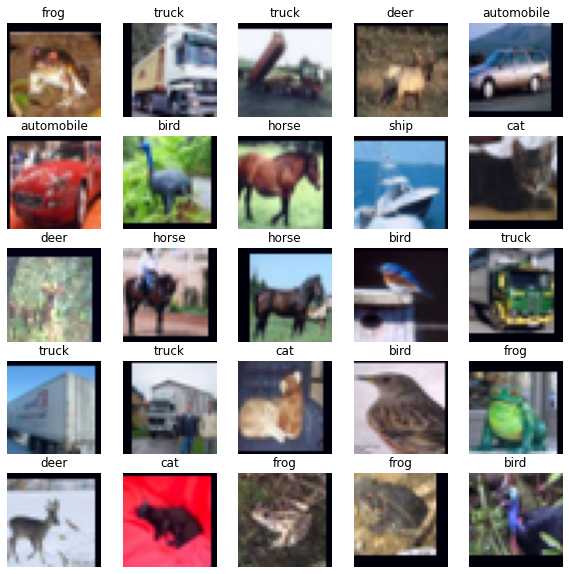

In [9]:
plot_images(images, labels, classes, normalize = True)

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [11]:


class BasicBlockKernel(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlockKernel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=1,
                               stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



Created a custom Resnet function to test all configurations

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_channels = [64, 128, 256, 512], strides = [1, 2, 2, 2], linear_in= 512, in_planes = 64, avg_pool_size = 4, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = in_planes

        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.layers_list = []
        for i in range(len(num_blocks)):
            # Makes layers based on the num_blocks, num_channels, strides given
            self.layers_list.append(self._make_layer(block, num_channels[i], num_blocks[i], stride=strides[i]))
        self.layer1 = nn.Sequential(*self.layers_list)
        self.linear = nn.Linear(linear_in*block.expansion, num_classes)
        self.avg_pool_size = avg_pool_size

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = F.avg_pool2d(out, self.avg_pool_size)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [13]:
import os
import time

In [14]:
model = ResNet(BasicBlockKernel, [8, 7, 7, 7], [64, 128, 256, 512], [1, 2, 2, 2], 8192, avg_pool_size = 1).to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [17]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Change the checkpoint name below to save different model checkpoints. We are saving the model state, validation accuracy for each epoch in checkpoints. We are also printing validation loss and accuracy for each epoch.

In [18]:
def train(net, iterator, optimizer, criterion, device):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(iterator):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return train_loss / (batch_idx+1), 100.*correct / total

In [19]:
def evaluate(net, iterator, criterion, device):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(iterator):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)


    return test_loss / (batch_idx+1), 100.*correct / total

In [20]:
import time

def current_seconds_time():
    return round(time.time())

In [22]:
EPOCHS = 7

total_start_time = current_seconds_time()
best_valid_acc = 0
for epoch in range(EPOCHS):
  start_time = current_seconds_time()
  train_loss, train_accuracy = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_accuracy = evaluate(model, valid_iterator, criterion, device)
  if valid_accuracy > best_valid_acc:
    save_location = f"{proj_root}/model_"+str(7)+".pt"
    torch.save(model, save_location)
    best_valid_acc = valid_accuracy
  end_time = current_seconds_time()
  elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)
  print('Epoch %s, Train loss %s, Valid loss %s, Train accuracy %s, Valid accuracy %s Elapsed mins %s Elapsed secs %s'%(epoch, train_loss, valid_loss, train_accuracy, valid_accuracy, elapsed_mins, elapsed_secs))
total_end_time = current_seconds_time()
full_mins, full_secs = epoch_time(total_start_time, total_end_time)

Epoch 0, Train loss 1.9062735583971848, Valid loss 1.665146186351776, Train accuracy 33.81333333333333, Valid accuracy 40.4 Elapsed mins 0 Elapsed secs 58
Epoch 1, Train loss 1.7235304330560295, Valid loss 1.620936827659607, Train accuracy 37.684444444444445, Valid accuracy 42.12 Elapsed mins 0 Elapsed secs 57
Epoch 2, Train loss 1.6756550666283478, Valid loss 1.5653934788703918, Train accuracy 39.266666666666666, Valid accuracy 43.8 Elapsed mins 0 Elapsed secs 57
Epoch 3, Train loss 1.6433097205378793, Valid loss 1.5460903978347778, Train accuracy 40.53111111111111, Valid accuracy 43.94 Elapsed mins 0 Elapsed secs 58
Epoch 4, Train loss 1.6188470965081996, Valid loss 1.508949053287506, Train accuracy 41.25555555555555, Valid accuracy 45.52 Elapsed mins 0 Elapsed secs 57
Epoch 5, Train loss 1.5958682237700983, Valid loss 1.471838529109955, Train accuracy 42.49111111111111, Valid accuracy 45.9 Elapsed mins 0 Elapsed secs 57
Epoch 6, Train loss 1.568638739599423, Valid loss 1.47307651281

In [23]:
print(f"Total time elapsed: {full_mins}m {full_secs}s")
print(f"Best valid accuracy: {best_valid_acc}%")

Total time elapsed: 6m 42s
Best valid accuracy: 46.78%
